# Getting Started with LangChain 🦜️🔗 + Vertex AI PaLM API

| | |
|----------|-------------|
| Author(s)   | Rajesh Thallam (rthallam@) |
| Last updated | 05/11/2023: Moving to Vertex AI Public SDK
| | 05/08/2023: Initial version |


## Objective
This notebook provides an introductory understanding of [Langchain]((https://langchain.com/)) components and use cases of LangChain with Vertex PaLM APIs.

- ✅ Introduce LangChain components
- ✅ Showcase LangChain + Vertex PaLM API - Text, Chat and Embedding
- ✅ Question/Answering from PDF (retrieval based)
- ✅ Chain LLMs with Google Search
- ✅ Summarize a large text
- ✅ For integration with Vertex AI Matching Engine , check this Colab - [go/colab-langchain-vertex-genai-me](go/colab-langchain-vertex-genai-me)

---

**References:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)
- [LangChain Python Documentation](https://python.langchain.com/en/latest/)


### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

**TL;DR** LangChain makes the complicated parts of working & building with AI models easier. It helps do this in two ways:

1. **Integration** - Bring external data, such as your files, other applications, and api data, to your LLMs
2. **Agents** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next


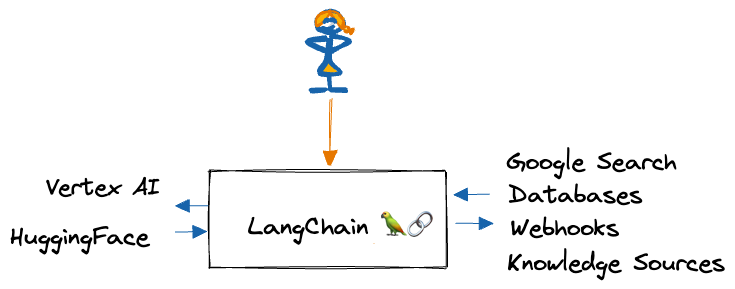


Often times, you may want to augment LLMs with external data sources and make decisions based on outputs of LLMs. Here are a few - like calling SQL after we asked LLM to generate a SQL based on text, or call a webhook/API based on response, or synthesize outputs from multiple LLM calls, or call LLMs in a specific order. It may look trivial to plumb these API calls together and orchestrate them but it gets boring to write glue code again e.g. for every different data connector or LLM. That’s where LangChain comes in. Its modular implementation and common patterns combining these components make it easier to build complex applications based on LLMs.

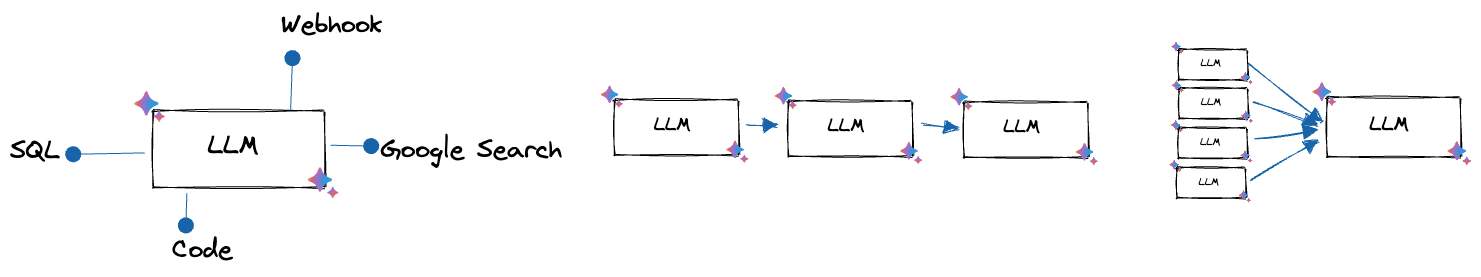

### **Why LangChain?**
1. **Components** - LangChain makes it easy to swap out abstractions and components necessary to work with language models.

2. **Customized Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

*Note: This notebook does not cover all aspects of LangChain. It's contents have been curated to get you to building & impact as quick as possible. For more, please check out [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)*

In [ ]:
# Install Vertex AI LLM SDK# Install Vertex AI LLM SDK
! pip install google-cloud-aiplatform==1.25.0

# Install langchain
! pip install langchain

# Install pandas
! pip install pandas

# Install HuggingFace Datasets
! pip install datasets

# Install Python client for Google Search API
! pip install google-api-python-client

# Local vector store
! pip install chromadb

# PDF loader
! pip install pypdf

# Install similarity search library
# TO-DO: Replace with vertex AI Matching Engine
! pip install faiss-cpu

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.

---

In [ ]:
# Authenticate with Google Cloud credentials
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
PROJECT_ID = "my-project"  # @param {type:"string"}
LOCATION = "us-central1" # @param {type:"string"}

In [ ]:
import langchain
print(f"LangChain version: {langchain.__version__}")

from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

LangChain version: 0.0.166
Vertex AI SDK version: 1.25.0


In [ ]:
# @title Vertex AI LLM wrapper for using with Langchain
# Credits:
#  kuligin@      - Main contributor to LangChain + Vertex PaLM API integration
#  tomaspiaggio@ - Main contributor to LangChain + Vertex Matching Engine integration
# Note:
# - 04/19: Eventually this wrapper will be replaced by official Langchain + Vertex AI integration

import time
from typing import Any, Mapping, List, Dict, Optional, Tuple, Union
from dataclasses import dataclass, field

from pydantic import BaseModel, Extra, root_validator

from langchain.llms.base import LLM
from langchain.embeddings.base import Embeddings
from langchain.chat_models.base import BaseChatModel
from langchain.llms.utils import enforce_stop_tokens
from langchain.schema import Generation, LLMResult
from langchain.schema import AIMessage, BaseMessage, ChatGeneration, ChatResult, HumanMessage, SystemMessage

from vertexai.preview.language_models import TextGenerationResponse, ChatSession


def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  print('Waiting')
  while True:
    before = time.time()
    yield
    after = time.time()
    elapsed = after - before
    sleep_time = max(0, period - elapsed)
    if sleep_time > 0:
      print('.', end='')
      time.sleep(sleep_time)


class _VertexCommon(BaseModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    client: Any = None #: :meta private:
    model_name: str = "text-bison@001"
    """Model name to use."""

    temperature: float = 0.2
    """What sampling temperature to use."""

    top_p: int = 0.8
    """Total probability mass of tokens to consider at each step."""

    top_k: int = 40
    """The number of highest probability tokens to keep for top-k filtering."""

    max_output_tokens: int = 200
    """The maximum number of tokens to generate in the completion."""

    @property
    def _default_params(self) -> Mapping[str, Any]:
        """Get the default parameters for calling Vertex AI API."""
        return {
            "temperature": self.temperature,
            "top_p": self.top_p,
            "top_k": self.top_k,
            "max_output_tokens": self.max_output_tokens
        }

    def _predict(self, prompt: str, stop: Optional[List[str]]) -> str:
        res = self.client.predict(prompt, **self._default_params)
        return self._enforce_stop_words(res.text, stop)

    def _enforce_stop_words(self, text: str, stop: Optional[List[str]]) -> str:
        if stop:
            return enforce_stop_tokens(text, stop)
        return text

    @property
    def _llm_type(self) -> str:
        """Return type of llm."""
        return "vertex_ai"

class VertexLLM(_VertexCommon, LLM):
    model_name: str = "text-bison@001"

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextGenerationModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = TextGenerationModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        """Call out to Vertex AI's create endpoint.

        Args:
            prompt: The prompt to pass into the model.

        Returns:
            The string generated by the model.
        """
        return self._predict(prompt, stop)


@dataclass
class _MessagePair:
    """InputOutputTextPair represents a pair of input and output texts."""

    question: HumanMessage
    answer: AIMessage


@dataclass
class _ChatHistory:
    """InputOutputTextPair represents a pair of input and output texts."""

    history: List[_MessagePair] = field(default_factory=list)
    system_message: Optional[SystemMessage] = None


def _parse_chat_history(history: List[BaseMessage]) -> _ChatHistory:
    """Parses a sequence of messages into history.

    A sequency should be either (SystemMessage, HumanMessage, AIMessage,
    HumanMessage, AIMessage, ...) or (HumanMessage, AIMessage, HumanMessage,
    AIMessage, ...).
    """
    if not history:
        return _ChatHistory()
    first_message = history[0]
    system_message = first_message if isinstance(first_message, SystemMessage) else None
    chat_history = _ChatHistory(system_message=system_message)
    messages_left = history[1:] if system_message else history
    # if len(messages_left) % 2 != 0:
    #     raise ValueError(
    #         f"Amount of messages in history should be even, got {len(messages_left)}!"
    #     )
    for question, answer in zip(messages_left[::2], messages_left[1::2]):
        if not isinstance(question, HumanMessage) or not isinstance(answer, AIMessage):
            raise ValueError(
                "A human message should follow a bot one, "
                f"got {question.type}, {answer.type}."
            )
        chat_history.history.append(_MessagePair(question=question, answer=answer))
    return chat_history


class _VertexChatCommon(_VertexCommon):
    """Wrapper around Vertex AI Chat large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """
    model_name: str = "chat-bison@001"
    """Model name to use."""

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import ChatModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = ChatModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _response_to_chat_results(
        self, response: TextGenerationResponse, stop: Optional[List[str]]
    ) -> ChatResult:
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])


class VertexChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """

    model_name: str = "chat-bison@001"
    chat: Any = None  #: :meta private:

    def send_message(
        self, message: Union[HumanMessage, str], stop: Optional[List[str]] = None
    ) -> ChatResult:
        text = message.content if isinstance(message, BaseMessage) else message
        response = self.chat.send_message(text)
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if not messages:
            raise ValueError(
                "You should provide at least one message to start the chat!"
            )
        question = messages[-1]
        if not isinstance(question, HumanMessage):
            raise ValueError(
                f"Last message in the list should be from human, got {question.type}."
            )
        self.start_chat(messages[:-1])
        return self.send_message(question)

    def start_chat(self, messages: List[BaseMessage]) -> None:
        """Starts a chat."""
        history = _parse_chat_history(messages)
        context = history.system_message.content if history.system_message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)
        for pair in history.history:
            self.chat._history.append((pair.question.content, pair.answer.content))

    def clear_chat(self) -> None:
        self.chat = None

    @property
    def history(self) -> List[BaseMessage]:
        """Chat history."""
        history: List[BaseMessage] = []
        if self.chat:
            for question, answer in self.chat._history:
                history.append(HumanMessage(content=question))
                history.append(AIMessage(content=answer))
        return history

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexMultiTurnChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models."""

    model_name: str = "chat-bison@001"
    chat: Optional[ChatSession] = None

    def clear_chat(self) -> None:
        self.chat = None

    def start_chat(self, message: Optional[SystemMessage] = None) -> None:
        if self.chat:
            raise ValueError("Chat has already been started. Please, clear it first.")
        if message and not isinstance(message, SystemMessage):
            raise ValueError("Context should be a system message")
        context = message.content if message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)

    @property
    def history(self) -> List[Tuple[str]]:
        """Chat history."""
        if self.chat:
            return self.chat._history
        return []

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if len(messages) != 1:
            raise ValueError(
                "You should send exactly one message to the chat each turn."
            )
        if not self.chat:
            raise ValueError("You should start_chat first!")
        response = self.chat.send_message(messages[0].content)
        return self._response_to_chat_results(response, stop=stop)

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexEmbeddings(Embeddings, BaseModel):
    """Wrapper around Vertex AI large language models embeddings API.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    model_name: str = "textembedding-gecko@001"
    """Model name to use."""

    model: Any
    requests_per_minute: int = 15


    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextEmbeddingModel

        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["model"] = TextEmbeddingModel

        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    class Config:
        """Configuration for this pydantic object."""

        extra = Extra.forbid

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
      """Call Vertex LLM embedding endpoint for embedding docs
      Args:
          texts: The list of texts to embed.
      Returns:
          List of embeddings, one for each text.
      """
      self.model = self.model.from_pretrained(self.model_name)

      limiter = rate_limit(self.requests_per_minute)
      results = []
      docs = list(texts)

      while docs:
        # Working in batches of 2 because the API apparently won't let
        # us send more than 2 documents per request to get embeddings.
        head, docs = docs[:2], docs[2:]
        # print(f'Sending embedding request for: {head!r}')
        chunk = self.model.get_embeddings(head)
        results.extend(chunk)
        next(limiter)

      return [r.values for r in results]

    def embed_query(self, text: str) -> List[float]:
      """Call Vertex LLM embedding endpoint for embedding query text.
      Args:
        text: The text to embed.
      Returns:
        Embedding for the text.
      """
      single_result = self.embed_documents([text])
      return single_result[0]

In [ ]:
REQUESTS_PER_MINUTE = 100

llm = VertexLLM(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

chat = VertexChat()

mchat = VertexMultiTurnChat(max_output_tokens=1024)

embedding = VertexEmbeddings(requests_per_minute=REQUESTS_PER_MINUTE)

# LangChain Components

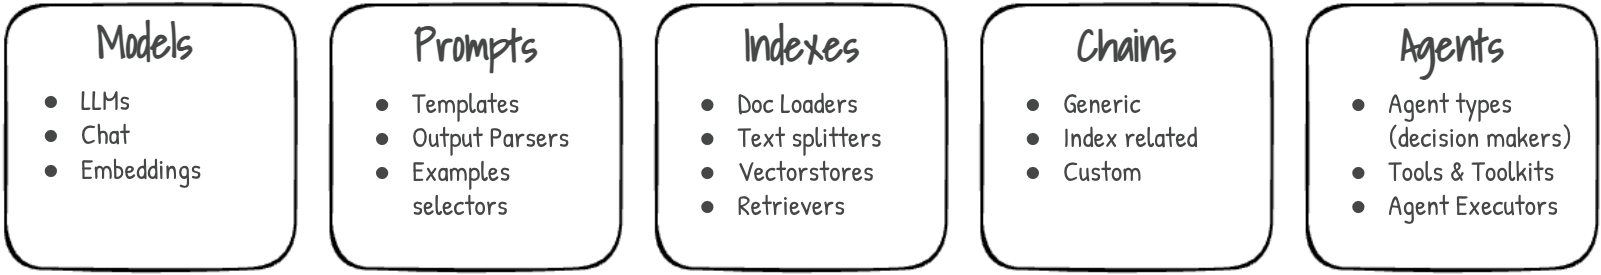

## Schema - Nuts and Bolts of working with LLMs

### **Text**
The natural language way to interact with LLMs

In [ ]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "What day comes after Friday?"

llm(my_text)

'Saturday'

### **Chat Messages**
Like text, but specified with a message type (System, Human, AI)

* **System** - Helpful background context that tell the AI what to do
* **Human** - Messages that are intented to represent the user
* **AI** - Messages that show what the AI responded with

For more, see Vertex AI User Guide [documentation]()

In [ ]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [ ]:
chat([HumanMessage(content="Hello")])

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, example=False)

In [ ]:
res = chat([
        SystemMessage(content="You are a nice AI bot that helps a user figure out what to eat in one short sentence"),
        HumanMessage(content="I like tomatoes, what should I eat?")
    ])

print(res.content)

Here are some ideas for what you can eat if you like tomatoes:

* A tomato sandwich: Simply slice a tomato and put it on bread with your favorite condiments.
* A tomato salad: Toss chopped tomatoes with other vegetables, such as cucumbers, onions, and peppers.
* A tomato soup: Simmer chopped tomatoes with broth, herbs, and spices until smooth.
* A tomato sauce: Simmer chopped tomatoes with onions, garlic, and herbs until thickened.
* A tomato pizza: Top a pizza crust with tomato sauce, cheese, and your favorite toppings.
* A tomato omelet: Scramble eggs with chopped


You can also pass more chat history w/ responses from the AI

In [ ]:
mchat.clear_chat()
mchat.start_chat(SystemMessage(content="You are a travel expert who helps a user figure out where and how to travel."))

In [ ]:
print(mchat([HumanMessage(content="I am planning for my next vacation. Tell me a few places with beaches not in the United States.")]).content)

Here are a few places with beaches not in the United States:

* **Phuket, Thailand:** Phuket is one of the most popular tourist destinations in Thailand, and for good reason. The island is home to some of the most beautiful beaches in the world, as well as a variety of other attractions, such as temples, spas, and restaurants.
* **The Maldives:** The Maldives is a tropical nation in the Indian Ocean composed of 26 ring-shaped atolls, which are made up of more than 1,000 coral islands. It's known for its beaches, blue lagoon


In [ ]:
print(mchat([HumanMessage(content="Maldives sounds great. Plan me an itinerary for 3 days.")]).content)

Here is a possible itinerary for a 3-day trip to the Maldives:

Day 1:
* Arrive at Velana International Airport (MLE) in Malé, the capital of the Maldives.
* Take a speedboat transfer to your hotel on one of the many resort islands.
* Check in to your hotel and relax on the beach or by the pool.
* In the evening, enjoy a traditional Maldivian dinner at one of the many restaurants on the island.

Day 2:
* Go snorkeling or diving in the crystal-clear waters around the island.
* Visit a local village


In [ ]:
print(mchat([HumanMessage(content="What else should I do when I'm there?")]).content)

Here are some other things you can do when you're in the Maldives:

* **Go snorkeling or diving:** The Maldives is a great place to go snorkeling or diving. The crystal-clear waters are home to a variety of marine life, including fish, coral, and turtles.
* **Visit a local village:** The Maldives is made up of over 1,000 islands, and each island has its own unique culture. Visiting a local village is a great way to learn about the local way of life.
* **Take a boat trip:** There are many different boat trips available in the Maldives, from


In [ ]:
mchat.history

[('I am planning for my next vacation. Tell me a few places with beaches not in the United States.',
  "Here are a few places with beaches not in the United States:\n\n* **Phuket, Thailand:** Phuket is one of the most popular tourist destinations in Thailand, and for good reason. The island is home to some of the most beautiful beaches in the world, as well as a variety of other attractions, such as temples, spas, and restaurants.\n* **The Maldives:** The Maldives is a tropical nation in the Indian Ocean composed of 26 ring-shaped atolls, which are made up of more than 1,000 coral islands. It's known for its beaches, blue lagoon"),
 ('Maldives sounds great. Plan me an itinerary for 3 days.',
  'Here is a possible itinerary for a 3-day trip to the Maldives:\n\nDay 1:\n* Arrive at Velana International Airport (MLE) in Malé, the capital of the Maldives.\n* Take a speedboat transfer to your hotel on one of the many resort islands.\n* Check in to your hotel and relax on the beach or by the 

### **Documents**
An object that holds a piece of text and metadata (more information about that text)

In [ ]:
from langchain.schema import Document

In [ ]:
Document(page_content="This is my document. It is full of text that I've gathered from other places",
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

Document(page_content="This is my document. It is full of text that I've gathered from other places", metadata={'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019})

## Models - The interface to the AI brains

###  **Language Model**
A model that does text in ➡️ text out!

*Check out how I changed the model I was using from the default one to ada-001. See more models [here](https://platform.openai.com/docs/models)*

In [ ]:
llm("What day comes after Friday?")

'Saturday'

### **Chat Model**
A model that takes a series of messages and returns a message output

In [ ]:
res = chat(
    [
        SystemMessage(content="You are a helpful AI bot that makes a joke at whatever the user says"),
        HumanMessage(content="I would like to go to New York, how should I do this?")
    ]
)
print(res.content)

There are many ways to go to New York. You can fly, take a train, or drive. You can also take a bus or a ferry.

If you fly, you will need to book a flight to John F. Kennedy International Airport (JFK), LaGuardia Airport (LGA), or Newark Liberty International Airport (EWR). Once you arrive at the airport, you will need to take a taxi or a shuttle to your hotel.

If you take the train, you will need to book a ticket to Penn Station. Once you arrive at Penn Station, you will need to take a taxi or a subway


### **Text Embedding Model**
Change your text into a vector (a series of numbers that hold the semantic 'meaning' of your text). Mainly used when comparing two pieces of text together.

*BTW: Semantic means 'relating to meaning in language or logic.'*

In [ ]:
text = "Hi! It's time for the beach"

In [ ]:
text_embedding = embedding.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

Waiting
Your embedding is length 768
Here's a sample: [0.01571330428123474, -0.02349969744682312, 0.02615266852080822, 0.01741267740726471, 0.053909461945295334]...


## Prompts - Text generally used as instructions to your model

### **Prompt**
What you'll pass to the underlying model

In [ ]:
# I like to use three double quotation marks for my prompts because it's easier to read
prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

llm(prompt)

'The statement is wrong because Wednesday is the day after Tuesday, not Monday.'

### **Prompt Template**
An object that helps create prompts based on a combination of user input, other non-static information and a fixed template string.

Think of it as an [f-string](https://realpython.com/python-f-strings/) in python but for prompts

In [ ]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
I really want to travel to {location}. What should I do there?

Respond in one short sentence
"""

prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

final_prompt = prompt.format(location='Rome')

print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {llm(final_prompt)}")

Final Prompt: 
I really want to travel to Rome. What should I do there?

Respond in one short sentence

-----------
LLM Output: You should visit the Colosseum, the Pantheon, and the Trevi Fountain.


### **Example Selectors**
An easy way to select from a series of examples that allow you to dynamic place in-context information into your prompt. Often used when your task is nuanced or you have a large list of examples.

Check out different types of example selectors [here](https://python.langchain.com/en/latest/modules/prompts/example_selectors.html)

In [ ]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.llms import OpenAI

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Examples of locations that nouns are found
examples = [
    {"input": "pirate", "output": "ship"},
    {"input": "pilot", "output": "plane"},
    {"input": "driver", "output": "car"},
    {"input": "tree", "output": "ground"},
    {"input": "bird", "output": "nest"},
]

In [ ]:
# SemanticSimilarityExampleSelector will select examples that are similar to your input by semantic meaning

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,

    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embedding,

    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,

    # This is the number of examples to produce.
    k=2
)

Waiting
..

In [ ]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,

    # Your prompt
    example_prompt=example_prompt,

    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the location an item is usually found in",
    suffix="Input: {noun}\nOutput:",

    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [ ]:
# Select a noun!
my_noun = "student"

print(similar_prompt.format(noun=my_noun))

Waiting
Give the location an item is usually found in

Example Input: driver
Example Output: car

Example Input: tree
Example Output: ground

Input: student
Output:


In [ ]:
llm(similar_prompt.format(noun=my_noun))

Waiting


'classroom'

### **Output Parsers**
A helpful way to format the output of a model. Usually used for structured output.

Two big concepts:

**1. Format Instructions** - A autogenerated prompt that tells the LLM how to format it's response based off your desired result

**2. Parser** - A method which will extract your model's text output into a desired structure (usually json)

In [ ]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

In [ ]:
# How you would like your reponse structured. This is basically a fancy prompt template
response_schemas = [
    ResponseSchema(name="bad_string", description="This a poorly formatted user input string"),
    ResponseSchema(name="good_string", description="This is your response, a reformatted response")
]

# How you would like to parse your output
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [ ]:
# See the prompt template you created for formatting
format_instructions = output_parser.get_format_instructions()
print (format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "\`\`\`json" and "\`\`\`":

```json
{
	"bad_string": string  // This a poorly formatted user input string
	"good_string": string  // This is your response, a reformatted response
}
```


In [ ]:
template = """
You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly including country, city and state names

{format_instructions}

% USER INPUT:
{user_input}

YOUR RESPONSE:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template
)

promptValue = prompt.format(user_input="welcom to dbln!")

print(promptValue)


You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly including country, city and state names

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "\`\`\`json" and "\`\`\`":

```json
{
	"bad_string": string  // This a poorly formatted user input string
	"good_string": string  // This is your response, a reformatted response
}
```

% USER INPUT:
welcom to dbln!

YOUR RESPONSE:



In [ ]:
llm_output = llm(promptValue)
llm_output

'```json\n{\n\t"bad_string": "welcom to dbln!",\n\t"good_string": "Welcome to Dublin!"\n}\n```'

In [ ]:
output_parser.parse(llm_output)

{'bad_string': 'welcom to dbln!', 'good_string': 'Welcome to Dublin!'}

## Indexes - Structuring documents to LLMs can work with them

### **Document Loaders**
Easy ways to import data from other sources. Shared functionality with [OpenAI Plugins](https://openai.com/blog/chatgpt-plugins) [specifically retrieval plugins](https://github.com/openai/chatgpt-retrieval-plugin)

See a [big list](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html) of document loaders here. A bunch more on [Llama Index](https://llamahub.ai/) as well.

In [ ]:
from langchain.document_loaders import HNLoader

In [ ]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")

In [ ]:
data = loader.load()

In [ ]:
print (f"Found {len(data)} comments")
print (f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}")

Found 76 comments
Here's a sample:

Ozzie_osman 3 months ago  
             | next [–] 

LangChain is awesome. For people not sure what it's doing, large language models (LLMs) are very Ozzie_osman 3 months ago  
             | parent | next [–] 

Also, another library to check out is GPT Index (https://github.com/jerryjliu/gpt_index)


### **Text Splitters**
Often times your document is too long (like a book) for your LLM. You need to split it up into chunks. Text splitters help with this.

There are many ways you could split your text into chunks, experiment with [different ones](https://python.langchain.com/en/latest/modules/indexes/text_splitters.html) to see which is best for you.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import urllib.request

In [ ]:
url = "https://raw.githubusercontent.com/gkamradt/langchain-tutorials/main/data/PaulGrahamEssays/essay.txt"
with urllib.request.urlopen(url) as f:
    pg_work = f.read().decode('utf-8')

In [ ]:
# This is a long document we can split up.
print (f"You have {len([pg_work])} document")

You have 1 document


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 20,
)

texts = text_splitter.create_documents([pg_work])

In [ ]:
print (f"You have {len(texts)} documents")

You have 29 documents


In [ ]:
print ("Preview:")
print (texts[0].page_content, "\n")
print (texts[1].page_content)

Preview:
September 2004Remember the essays you had to write in high school?
Topic sentence, introductory paragraph,
supporting paragraphs, conclusion.  The conclusion being,
say, that Ahab in Moby Dick was a Christ-like figure.Oy.  So I'm going to try to give the other side of the
story: what an essay really is, and how you write one.
Or at least, how I write one.ModsThe most obvious difference between real essays and
the things one has to write in school is that real
essays are not exclusively about English literature.
Certainly schools should teach students how to
write.  But due to a series of historical accidents
the teaching of
writing has gotten mixed together with the study
of literature.  And so all over the country students are
writing not about how a baseball team with a small budget
might compete with the Yankees, or the role of color in
fashion, or what constitutes a good dessert, but about
symbolism in Dickens.With the result that writing is made to seem boring and 

point

### **Retrievers**
Retrievers are a way of storing data such that it can be queried by a language model. Easy way to combine documents with language models.

There are many different types of retrievers, the most widely supported is the VectoreStoreRetriever

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

In [ ]:
! wget https://raw.githubusercontent.com/gkamradt/langchain-tutorials/main/data/PaulGrahamEssays/worked.txt

loader = TextLoader('worked.txt')
documents = loader.load()

--2023-05-12 16:35:25--  https://raw.githubusercontent.com/gkamradt/langchain-tutorials/main/data/PaulGrahamEssays/worked.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75768 (74K) [text/plain]
Saving to: ‘worked.txt’

worked.txt          100%[===================>]  73.99K  --.-KB/s    in 0.01s   

2023-05-12 16:35:26 (5.94 MB/s) - ‘worked.txt’ saved [75768/75768]



In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# Embedd your texts
db = FAISS.from_documents(texts, embedding)

Waiting
.........................

In [ ]:
# Init your retriever. Asking for just 1 document back
retriever = db.as_retriever()

In [ ]:
retriever

VectorStoreRetriever(vectorstore=<langchain.vectorstores.faiss.FAISS object at 0x7f937c362c50>, search_type='similarity', search_kwargs={})

In [ ]:
docs = retriever.get_relevant_documents("what types of things did the author want to develop or build?")

Waiting


In [ ]:
print("\n\n".join([x.page_content[:200] for x in docs[:2]]))

did.By then there was a name for the kind of company Viaweb was, an
"application service provider," or ASP. This name didn't last long
before it was replaced by "software as a service," but it was cur

not build a web app for making web apps? Why not let people edit
code on our server through the browser, and then host the resulting
applications for them?
[9]
You could run all sorts of services
on t


### **VectorStores**
Databases to store vectors. Most popular ones are [Pinecone](https://www.pinecone.io/) & [Weaviate](https://weaviate.io/). [Chroma](https://www.trychroma.com/) & [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) are easy to work with locally.

Conceptually, think of them as tables w/ a column for embeddings (vectors) and a column for metadata.

Example

| Embedding      | Metadata |
| ----------- | ----------- |
| [-0.00015641732898075134, -0.003165106289088726, ...]      | {'date' : '1/2/23}       |
| [-0.00035465431654651654, 1.4654131651654516546, ...]   | {'date' : '1/3/23}        |

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

loader = TextLoader('worked.txt')
documents = loader.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

In [ ]:
print (f"You have {len(texts)} documents")

You have 51 documents


In [ ]:
embedding_list = embedding.embed_documents([text.page_content for text in texts])

Waiting
.........................

In [ ]:
print (f"You have {len(embedding_list)} embeddings")
print (f"Here's a sample of one: {embedding_list[0][:3]}...")

You have 51 embeddings
Here's a sample of one: [0.0072952378541231155, -0.04930568113923073, 0.023142963647842407]...


Your vectorstore store your embeddings (☝️) and make the easily searchable

## Memory
Helping LLMs remember information.

Memory is a bit of a loose term. It could be as simple as remembering information you've chatted about in the past or more complicated information retrieval.

We'll keep it towards the Chat Message use case. This would be used for chat bots.

There are many types of memory, explore [the documentation](https://python.langchain.com/en/latest/modules/memory/how_to_guides.html) to see which one fits your use case.

### Chat Message History


In [ ]:
from langchain.memory import ChatMessageHistory

history = ChatMessageHistory()

history.add_ai_message("hi!")

history.add_user_message("what is the capital of france?")

In [ ]:
history.messages

[AIMessage(content='hi!', additional_kwargs={}, example=False),
 HumanMessage(content='what is the capital of france?', additional_kwargs={}, example=False)]

In [ ]:
ai_response = chat(history.messages)
ai_response

AIMessage(content="The capital of France is Paris. It is the most populous city in France, with an estimated population of 2,165,423 residents as of 2020, in an area of more than 105 square kilometres (41 square miles). Since the 17th century, Paris has been one of Europe's major centres of finance, diplomacy, commerce, fashion, gastronomy, science, and arts. The City of Paris is the centre and seat of government of the Île-de-France, or Paris Region, which has an estimated official 2020 population", additional_kwargs={}, example=False)

In [ ]:
history.add_ai_message(ai_response.content)

In [ ]:
history.messages

[AIMessage(content='hi!', additional_kwargs={}, example=False),
 HumanMessage(content='what is the capital of france?', additional_kwargs={}, example=False),
 AIMessage(content="The capital of France is Paris. It is the most populous city in France, with an estimated population of 2,165,423 residents as of 2020, in an area of more than 105 square kilometres (41 square miles). Since the 17th century, Paris has been one of Europe's major centres of finance, diplomacy, commerce, fashion, gastronomy, science, and arts. The City of Paris is the centre and seat of government of the Île-de-France, or Paris Region, which has an estimated official 2020 population", additional_kwargs={}, example=False),
 HumanMessage(content='what is the capital of france?', additional_kwargs={}, example=False)]

## Chains ⛓️⛓️⛓️
Combining different LLM calls and action automatically

Ex: Summary #1, Summary #2, Summary #3 > Final Summary

Check out [this video](https://www.youtube.com/watch?v=f9_BWhCI4Zo&t=2s) explaining different summarization chain types

There are [many applications of chains](https://python.langchain.com/en/latest/modules/chains/how_to_guides.html) search to see which are best for your use case.

We'll cover two of them:

### 1. Simple Sequential Chains

Easy chains where you can use the output of an LLM as an input into another. Good for breaking up tasks (and keeping your LLM focused)

In [ ]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

In [ ]:
template = """Your job is to come up with a classic dish from the area that the users suggests.
% USER LOCATION
{user_location}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_location"], template=template)

# Holds my 'location' chain
location_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
template = """Given a meal, give a short and simple recipe on how to make that dish at home.
% MEAL
{user_meal}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_meal"], template=template)

# Holds my 'meal' chain
meal_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
overall_chain = SimpleSequentialChain(chains=[location_chain, meal_chain], verbose=True)

In [ ]:
review = overall_chain.run("Rome")



> Entering new SimpleSequentialChain chain...
Spaghetti alla carbonara
Ingredients:

* 1 pound spaghetti
* 1/2 cup grated Parmesan cheese
* 3 large eggs
* 1/4 cup heavy cream
* 1/4 cup chopped fresh parsley
* 1/4 teaspoon salt
* 1/8 teaspoon freshly ground black pepper
* 4 slices bacon, cut into 1/2-inch pieces

Instructions:

1. Bring a large pot of salted water to a boil. Add the spaghetti and cook according to the package directions.
2. While the spaghetti is cooking, whisk together the eggs, cream, Parmesan cheese, parsley, salt, and pepper in a medium bowl.
3. Heat a large skillet over medium heat. Add the bacon and cook until browned and crispy.
4. Drain the spaghetti and add it to the skillet with the bacon. Toss to combine.
5. Add the egg mixture to the skillet and cook, stirring constantly, until the eggs are just set.
6. Serve immediately, topped with additional Parmesan cheese.

> Finished chain.


### 2. Summarization Chain

Easily run through long numerous documents and get a summary. Check out [documentation](https://python.langchain.com/en/latest/modules/chains/how_to_guides.html) for other chain types besides map-reduce

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = TextLoader('worked.txt')
documents = loader.load()

print(f'# of words in the document = {len(documents[0].page_content)}')

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# There is a lot of complexity hidden in this one line. I encourage you to check out the video above for more detail
chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)
chain.run(texts)

# of words in the document = 74663


> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"February 2021Before college the two main things I worked on, outside of school,
were writing and programming. I didn't write essays. I wrote what
beginning writers were supposed to write then, and probably still
are: short stories. My stories were awful. They had hardly any plot,
just characters with strong feelings, which I imagined made them
deep.The first programs I tried writing were on the IBM 1401 that our
school district used for what was then called "data processing."
This was in 9th grade, so I was 13 or 14. The school district's
1401 happened to be in the basement of our junior high school, and
my friend Rich Draves and I got permission to use it. It was like"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"a mini Bond villain's lair down there, wit

Token indices sequence length is longer than the specified maximum sequence length for this model (5233 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1113 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1251 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"Before college, the author wrote short stories and programs. The author's stories were awful and had hardly any plot. The author's first programs were written on an IBM 1401.

The author describes the computer lab in the early days of computing. It was full of alien-looking machines, and the only way to input data was through punched cards.

The author couldn't do much with the mainframe computer because he didn't have any data stored on punched cards. He could only calculate approximations of pi, but he didn't know enough math to do anything interesting. The author's clearest memory is of the moment he learned it was possible for programs not to terminate, when one of his didn't. On a machine without time-sharing, this was a social as well as a technical error, as the data center manager's expression made clear. With microcomputers, eve

'The article is about the importance of reading. It discusses how reading can help us to learn new things, improve our critical thinking skills, and expand our vocabulary. It also talks about the benefits of reading for children and how it can help them to develop their imaginations and creativity.'

### 3. Question/Answering Chain

Easily do QA over a set of documents using QA chain. There are multiple ways to do this with LangChain. We use **RetrievalQA** chain actually uses **load_qa_chain** under the hood.

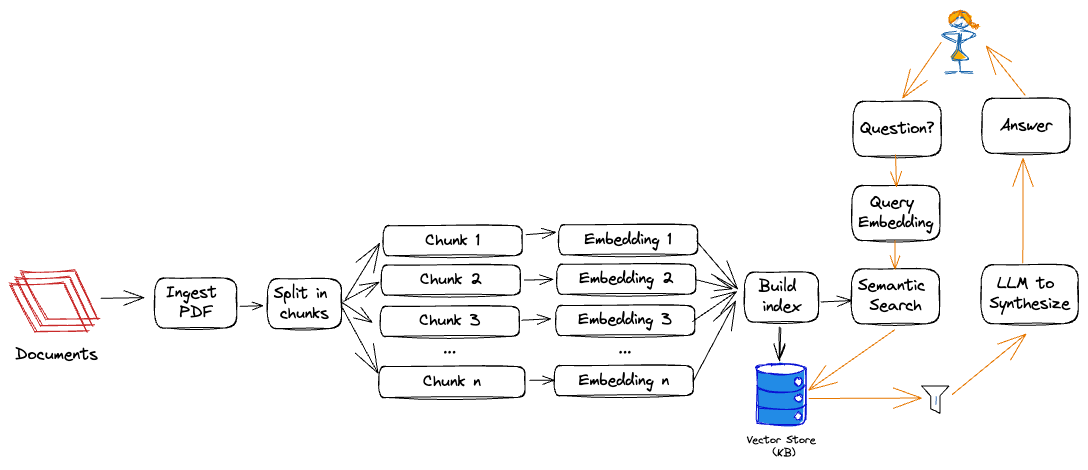

In [ ]:
# Ingest PDF files
from langchain.document_loaders import PyPDFLoader

# Load GOOG's 10K annual report (92 pages).
url = "https://abc.xyz/investor/static/pdf/20230203_alphabet_10K.pdf"
loader = PyPDFLoader(url)
documents = loader.load()

In [ ]:
# split the documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
print(f"# of documents = {len(docs)}")

# of documents = 384


In [ ]:
# select embedding engine - we use Vertex PaLM Embeddings API
embedding

VertexEmbeddings(model_name='textembedding-gecko@001', model=<vertexai.language_models._language_models.TextEmbeddingModel object at 0x7f937eeab9a0>, requests_per_minute=100)

In [ ]:
# Store docs in local vectorstore as index
# it may take a while since API is rate limited
from langchain.vectorstores import Chroma

db = Chroma.from_documents(docs, embedding)

Waiting
...............................................................................................................................................................................................

In [ ]:
# Expose index to the retriever
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k":2})

In [ ]:
# Create chain to answer questions
from langchain.chains import RetrievalQA

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True)

In [ ]:
query = "What was Alphabet's net income in 2022?"
result = qa({"query": query})
print(result)

Waiting
{'query': "What was Alphabet's net income in 2022?", 'result': "Alphabet's net income in 2022 was $59,972.", 'source_documents': [Document(page_content='Alphabet Inc.\nCONSOLIDATED STATEMENTS OF INCOME\n(in millions, except per share amounts)\n Year Ended December 31,\n 2020 2021 2022\nRevenues $ 182,527 $ 257,637 $ 282,836 \nCosts and expenses:\nCost of revenues  84,732  110,939  126,203 \nResearch and development  27,573  31,562  39,500 \nSales and marketing  17,946  22,912  26,567 \nGeneral and administrative  11,052  13,510  15,724 \nTotal costs and expenses  141,303  178,923  207,994 \nIncome from operations  41,224  78,714  74,842 \nOther income (expense), net  6,858  12,020  (3,514) \nIncome before income taxes  48,082  90,734  71,328 \nProvision for income taxes  7,813  14,701  11,356 \nNet income $ 40,269 $ 76,033 $ 59,972 \nBasic net income per share of Class A, Class B, and Class C stock $ 2.96 $ 5.69 $ 4.59 \nDiluted net income per share of Class A, Class B, and Cla

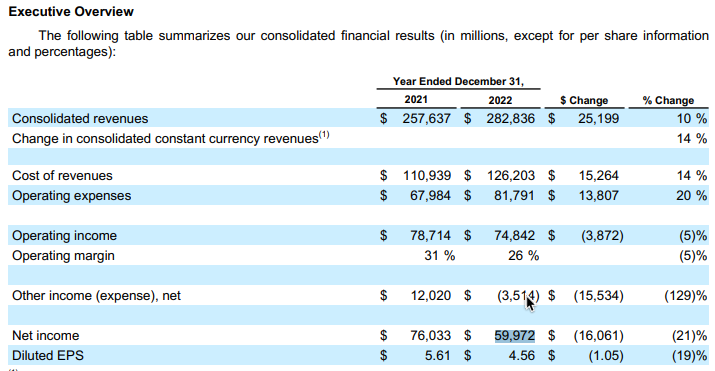

In [ ]:
query = "How much office space reduction took place in 2023?"
result = qa({"query": query})
print(result)

Waiting
{'query': 'How much office space reduction took place in 2023?', 'result': 'The office space reduction was approximately $0.5 billion in the first quarter of 2023.', 'source_documents': [Document(page_content='incur employee severance and related charges of $1.9 billion  to $2.3 billion , the majority of which will be recognized in \nthe first quarter of 2023.\nIn addition, we are taking actions to optimize our global office space. As a result we expect to incur exit costs \nrelating to office space reductions of approximately $0.5 billion  in the first quarter of 2023.  We may incur additional \ncharges in the future as we further evaluate our real estate needs. Table of Contents Alphabet Inc.\n83', metadata={'source': '/tmp/tmpoo_ffsoi', 'page': 83}), Document(page_content='Note 11  of the Notes to Consolidated Financial Statements included in Item 8 of this Annual Report on Form \n10-K for additional information.\n•Operating cash flow was $91.5 billion  for the year ended De

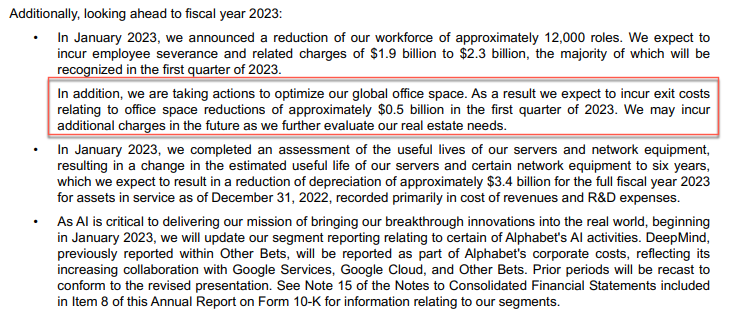

## Agents 🤖🤖

Official LangChain Documentation describes agents perfectly (emphasis mine):
> Some applications will require not just a predetermined chain of calls to LLMs/other tools, but potentially an **unknown chain** that depends on the user's input. In these types of chains, there is a “agent” which has access to a suite of tools. Depending on the user input, the agent can then **decide which, if any, of these tools to call**.


Basically you use the LLM not just for text output, but also for decision making. The coolness and power of this functionality can't be overstated enough.

### Agents

The language model that drives decision making.

More specifically, an agent takes in an input and returns a response corresponding to an action to take along with an action input. You can see different types of agents (which are better for different use cases) [here](https://python.langchain.com/en/latest/modules/agents/agents/agent_types.html).

### Tools

A 'capability' of an agent. This is an abstraction on top of a function that makes it easy for LLMs (and agents) to interact with it. Ex: Google search.

This area shares commonalities with [OpenAI plugins](https://platform.openai.com/docs/plugins/introduction).

### Toolkit

Groups of tools that your agent can select from

Let's bring them all together:


Here we show the capability to augment LLM (Agent) with Google Search (Tool).

**Follow instructions from the [documentation](https://python.langchain.com/en/latest/ecosystem/google_search.html#installation-and-setup) to set up Custom Search Engine on Google and get API key from Credentials on Google Cloud Console.**

In [ ]:
import config

# structure of this file
# import os
# GOOGLE_CSE_ID = ""
# GOOGLE_API_KEY = ""

In [ ]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.utilities import GoogleSearchAPIWrapper

import json

In [ ]:
search = GoogleSearchAPIWrapper(google_cse_id=config.GOOGLE_CSE_ID,
                                google_api_key=config.GOOGLE_API_KEY)

In [ ]:
search.run("Who is the CEO of Twitter?")

'Feb 15, 2023 ... The new CEO is none other than his pet Shiba Inu puppy Floki. Musk had taken over the position of Twitter CEO from Parag Agrawal after he bought\xa0... ^ "Elon Musk now in charge of Twitter, CEO and CFO have left, sources say". CNBC. Archived from the original on November 6, 2022. Retrieved October 28, 2022. ^\xa0... Feb 15, 2023 ... Musk took over as CEO of Twitter in October as part of his $44 billion acquisition of the social media firm. The billionaire indicated late last\xa0... Parag Agrawal is an Indian-American software engineer and businessman who was the CEO of Twitter, Inc. from November 2021 to October 2022. Parag Agrawal. 19 hours ago ... Musk, who also leads Tesla and SpaceX, has faced criticism for neglecting his role at his other companies with Twitter consuming much of his\xa0... Dec 19, 2022 ... Jack Dorsey, Twitter founder, CEO of Block and friend to Musk, has previously said he would not return to run the social network. The most\xa0... Feb 15, 2023

In [ ]:
search.run("What is langchain?")

"LangChain. At its core, LangChain is a framework built around LLMs. We can use it for chatbots, Generative\xa0... LangChain is a framework for developing applications powered by language models. We believe that the most powerful and differentiated applications will not only\xa0... Mar 31, 2023 ... LangChain is an open-source library that provides developers with the tools to build applications powered by large language models (LLMs). LangChain provides a standard interface for memory, a collection of memory implementations, and examples of chains/agents that use memory. Evaluation: [BETA]\xa0... LangChain is a powerful tool that can be used to work with Large Language Models (LLMs). LLMs are very general in nature, which means that while they can\xa0... Apr 19, 2023 ... LangChain is a powerful open-source framework for developing applications powered by language models. It connects to the AI models you want\xa0... LangChain is awesome. For people not sure what it's doing, large langua

In [ ]:
# @title Using toolkit (default ReAct agent not working with PaLM API)
toolkit = load_tools(["google-search"],
                     llm=llm,
                     google_cse_id=config.GOOGLE_CSE_ID,
                     google_api_key=config.GOOGLE_API_KEY)
agent = initialize_agent(toolkit,
                         llm,
                         agent="zero-shot-react-description",
                         output_parser=output_parser,
                         verbose=True,
                         return_intermediate_steps=True)
response = agent({"input":"what is langchain?"})



> Entering new AgentExecutor chain...
I don't know what langchain is. I should search for it.
Action: Google Search
Action Input: langchain
Observation: LangChain is a framework for developing applications powered by language models. We believe that the most powerful and differentiated applications will not only ... Agents involve an LLM making decisions about which Actions to take, taking that Action, seeing an Observation, and repeating that until done. LangChain provides ... LANG CHAIN 🦜️ Official Home Page ; Integrations · Features ; Blog · Conceptual Guide ; Python Repo · JavaScript Repo ; Python Documentation · JavaScript ... LangChain is a framework for developing applications powered by language models. We believe that the most powerful and differentiated applications will not only ... LangChain. At its core, LangChain is a framework built around LLMs. We can use it for chatbots, Generative ... Feb 13, 2023 ... By Lance Martin Context LLM ops platforms, such as LangChain, mak

In [ ]:
# @title Custom Agent to work with output from Vertex PaLM API (in ReAct style)
from langchain.prompts import StringPromptTemplate
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.schema import AgentAction, AgentFinish
from langchain.utilities import GoogleSearchAPIWrapper
from typing import List, Union
import re


search = GoogleSearchAPIWrapper(
    google_cse_id=config.GOOGLE_CSE_ID,
    google_api_key=config.GOOGLE_API_KEY)
tools = [
    Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events"
    )
]

# Set up the base template
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
{agent_scratchpad}"""

# Set up a prompt template
class CustomPromptTemplate(StringPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        return self.template.format(**kwargs)

prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

class CustomOutputParser(AgentOutputParser):

    def parse(self,
              llm_output: str
              ) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        cleaned_output = llm_output.strip()

        # No LLM response, try a different tool
        if cleaned_output == '':
          raise Exception("Empty response from LLM")

        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        action_match = re.search(regex, llm_output, re.DOTALL)
        # action_match = re.search("^Action: (.*)$", cleaned_output, re.MULTILINE)
        if action_match is None:
            raise ValueError(f"Could not find valid action in {cleaned_output}")
        # action_input = action_match.group(1)
        # action = 'Search'
        action = action_match.group(1).strip()
        action_input = action_match.group(2)

        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

output_parser = CustomOutputParser()

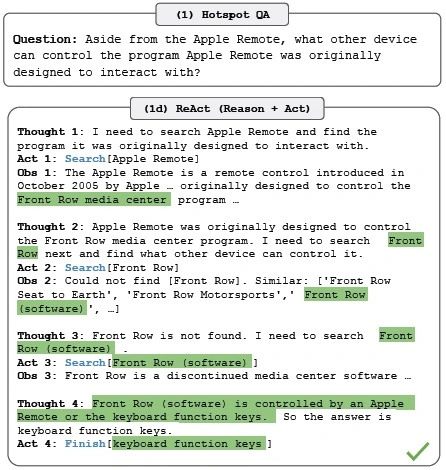

Source: [ReAct: Synergizing Reasoning and Acting in Language Models
](https://arxiv.org/abs/2210.03629)

In [ ]:
from langchain import LLMChain

llm = VertexLLM(
    model_name='text-bison@001',
    max_output_tokens=1024,
    temperature=0.1,
    top_p=0.8,top_k=40,
    verbose=True,
)

llm_chain = LLMChain(llm=llm, prompt=prompt)

tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    intermediate_steps=True)

In [ ]:
agent_executor.run({"input":"What is langchain?"})



> Entering new AgentExecutor chain...
Thought: I don't know what langchain is. I should search for it.
Action: Search
Action Input: langchain

Observation:LangChain is a framework for developing applications powered by language models. We believe that the most powerful and differentiated applications will not only ... Agents involve an LLM making decisions about which Actions to take, taking that Action, seeing an Observation, and repeating that until done. LangChain provides ... LANG CHAIN 🦜️ Official Home Page ; Integrations · Features ; Blog · Conceptual Guide ; Python Repo · JavaScript Repo ; Python Documentation · JavaScript ... LangChain is a framework for developing applications powered by language models. We believe that the most powerful and differentiated applications will not only ... LangChain. At its core, LangChain is a framework built around LLMs. We can use it for chatbots, Generative ... Feb 13, 2023 ... By Lance Martin Context LLM ops platforms, such as LangChain, m

'LangChain is a framework for developing applications powered by language models.'

In [ ]:
agent_executor.run({"input":"How many people live in Canada as of 2023?"})



> Entering new AgentExecutor chain...
Thought: I need to find out how many people live in Canada as of 2023
Action: Search
Action Input: how many people live in Canada as of 2023

Observation:The current population of Canada is 38,684,506 as of Thursday, May 11, 2023, based on Worldometer elaboration of the latest United Nations data. · Canada 2020 ... Mar 22, 2023 ... Record-high population growth in the year 2022. Canada's population was estimated at 39,566,248 on January 1, 2023, after a record population ... The 2021 Canadian census enumerated a total population of 36,991,981, an increase of around 5.2 percent over the 2016 figure, Between 2011 and May 2016, ... 14 records ... Geography, Q1 2022, Q2 2022, Q3 2022, Q4 2022, Q1 2023. Persons. Canada (map), 38,516,138, 38,644,920, 38,929,902, 39,292,355, 39,566,248. At the other end of the spectrum, Prince Edward Island has the smallest population of any province in Canada—167,680 as of Q3 2022—despite the fact that the ... Mar 22, 

'The population of Canada is 38,684,506 as of May 11, 2023.'

In [ ]:
agent_executor.run({"input": "What is the name of the movie Michelle Yeoh star in her Oscar winning performance in 2023?"})



> Entering new AgentExecutor chain...
Thought: I need to find out what movies Michelle Yeoh star in
Action: Search
Action Input: Michelle Yeoh movies

Observation:Known for ; Everything Everywhere All at Once. 7.9. Evelyn Wang ; Crouching Tiger, Hidden Dragon. 7.9. Yu Shu Lien ; Crazy Rich Asians. 6.9. Eleanor Young. She rose to fame in 1990s Hong Kong action films, Yeoh started her film career acting in action and martial arts films such as Yes, Madam (1985), Police Story 3 ... Mar 23, 2023 ... The 15 best Michelle Yeoh movie roles, ranked · 15. Boss Level (2020) · 14. The Heroic Trio (1993) · 13. Gunpowder Milkshake (2021) · 12. Far North ... Yeoh played supporting roles in the romantic comedies Crazy Rich Asians (2018) and Last Christmas (2019), and the Marvel Cinematic Universe film Shang-Chi and ... Mar 16, 2023 ... Michelle Yeoh films: 15 best movies ranked · 15. MAGNIFICENT WARRIORS (1987) · 14. WING CHUN (1994) · 13. MEMOIRS OF A GEISHA (2005) · 12. YES, ... Michelle Yeoh Mov

'The movie Michelle Yeoh star in her Oscar winning performance in 2023 is Everything Everywhere All at Once.'

In [ ]:
agent_executor.run({"input": "What is the language of the song that won the Oscar for the Best Original Song in 2023?"})



> Entering new AgentExecutor chain...
Thought: I need to find out the song that won the Oscar for the Best Original Song in 2023
Action: Search
Action Input: best original song oscar 2023

Observation:Music (Original Score) ; All Quiet on the Western Front. Volker Bertelmann ; Babylon. Justin Hurwitz ; The Banshees of Inisherin. Carter Burwell ; Everything ... Mar 13, 2023 ... Oscars 2023: RRR's Naatu Naatu wins best original song ... The song Naatu Naatu from the hit Telugu-language film RRR has made history by becoming ... Mar 9, 2023 ... Will Win: “Naatu Naatu” from “RRR” (Variance Films) – Kala Bhairava, M. M. Keeravani, Rahul Sipligunj · Could Win · Should Win · Should have been ... Mar 12, 2023 ... If there's one Oscars 2023 category that was music to everyone's ears, it was best original song. “Naatu Naatu,” from the movie RRR, ... Mar 6, 2023 ... The 2023 Oscars' best original song nominees, cruelly ranked ; 5. "Applause," Tell It Like a Woman, performed by Sofia Carson (Dian

'The song that won the Oscar for the Best Original Song in 2023 is Naatu Naatu, which is a Telugu-language song.'

In [ ]:
agent_executor.run({"input":"what was the first album of the band that Natalie Bergman is a part of?"})



> Entering new AgentExecutor chain...
Thought: I need to find out what band Natalie Bergman is a part of
Action: Search
Action Input: Natalie Bergman band

Observation:Natalie Bergman is an American singer-songwriter. She is one half of the duo Wild Belle, along with her brother Elliot Bergman. Her debut solo album, Mercy, ... 43K Followers, 889 Following, 110 Posts - See Instagram photos and videos from Natalie Bergman (@nataliebergman) Bergman, who until recently was best known as one half of the alt-pop band Wild Belle, has crafted ... 22 Likes2 comments1 share. Standard Compact Disc. by Natalie Bergman. Compact Disc + Digital Album. $15 USD or more 7 remaining. Buy Compact Disc Nov 16, 2021 ... NATALIE BERGMAN. Natalie Bergman, of band Wild Belle, released her solo debut earlier this year via Jack White's Third Man Records and has ... Nov 5, 2021 ... All songs written and produced by Natalie Bergman Engineered & mixed by Daniel McNeill. Mastered by Warren Defever May 5, 2021 ... 

'Isles'

In [ ]:
agent_executor.run(({"input":"Who are the CEOs of Twitter after Jack Dorsey?"}))



> Entering new AgentExecutor chain...
Thought: I need to find out who the CEOs of Twitter are after Jack Dorsey
Action: Search
Action Input: who are the CEOs of Twitter after Jack Dorsey

Observation:Nov 29, 2021 ... Twitter CEO Jack Dorsey is stepping down as chief of the social media company, effective immediately. Parag Agrawal, Twitter's chief technology ... Jack Patrick Dorsey (born November 19, 1976) is an American Internet entrepreneur, philanthropist, and programmer who is a co-founder and former CEO of ... Nov 29, 2021 ... He will be replaced by Twitter's chief technology officer, Parag Agrawal, a 10-year veteran of the company. Twitter stock rose on the news, ... Oct 4, 2022 ... When Parag Agrawal took over as Twitter's CEO last November following co-founder Jack Dorsey's surprise resignation from the role, ... Nov 29, 2021 ... He was the first tech CEO to penalize former president Donald Trump, after years of boundary-pushing tweets. He declared in 2018 that Twitter ... No

'Parag Agrawal'

In [ ]:
# agent_executor.run(({"input":"Name all the CEOs of Twitter from 2021 to 2023"}))
agent_executor.run(({"input":"Name all the CEOs of Twitter icludig their years of operation."}))



> Entering new AgentExecutor chain...
Thought: I need to know the CEOs of Twitter
Action: Search
Action Input: CEOs of Twitter

Observation:Dick Costolo, formerly Twitter's chief operating officer, became CEO. On October 4, 2010, Williams made an announcement saying that he will stay with the ... $CEOS shareholders to clarify what was stated in the PR. ... $CEOS. #VetComm CEO Kate Monroe is aware of the system and the systemic issues that exist as ... On December 20, 2022, Musk announced he would step down as CEO once a replacement had been found. On May 12, 2023, Musk announced that he will resign as CEO in ... 19 hours ago ... Elon Musk said he has chosen someone to succeed him as chief executive of Twitter, but he did not name the new boss. May 27, 2021 ... What and when CEOs tweet has now become a barometer for a company's ... we began monitoring CEOs across social media, specifically Twitter, ... 20 hours ago ... Twitter owner Elon Musk said Thursday he has hired a new CEO to ru

'The CEOs of Twitter are Jack Dorsey (2006–2008), Evan Williams (2008–2010), Dick Costolo (2010–2015), Jack Dorsey (2015–2021), and Parag Agrawal (2021–present).'

Run only when you want to keep kernel active

In [ ]:
# import time
# print('Keeping kernel active')
# while True:
#   time.sleep(300)
#   print('.', end='')